# EDA

In [52]:
import pandas as pd
import pickle
import numpy as np
import matplotlib.pyplot as plt

In [53]:
press = pd.read_csv('./data/press.csv')
dtm = pickle.load(open('./data/df_dtm.pkl', 'rb'))

## Fréquence des termes

### Analyse

In [54]:
press

,newspaper,text,clean_text,relevent_text,stemmed_text
0,20minutes,CORONAVIRUS Après une alerte lancée il y a tro...,coronavirus apres une alerte lancee il y a tro...,coronavirus apres alerte lancee a trois semain...,coronavirus apre alert lance a trois semain fo...
1,bfm,"Parmi les trois foyers identifiés, l'un se tro...",parmi les trois foyers identifies l un se trou...,parmi trois foyers identifies trouve entrepris...,parm trois foyer identif trouv entrepris a fec...
2,cnews,La France a enregistré 16 décès supplémentaire...,la france a enregistre <NB> deces supplementai...,france a enregistre deces supplementaires lies...,franc a enregistr dec supplementair li coronav...
3,lacroix,Ne pas baisser la garde. C’est en résumé le me...,ne pas baisser la garde c est en resume le mes...,baisser garde resume message lance organisatio...,baiss gard resum messag lanc organis mondial s...
4,ledauphine,Un cas positif de Covid-19 a été détecté ce ve...,un cas positif de coronavirus a ete detecte ce...,cas positif coronavirus a ete detecte vendredi...,cas posit coronavirus a ete detect vendred jui...
5,lefigaro,"Sur un marché parisien, les commerçants prenne...",sur un marche parisien les commerçants prennen...,marche parisien commerçants prennent mesures l...,march parisien commerc prennent mesur limit co...
6,lemonde,"Le Brésil compte, samedi 20 juin, près d’un mi...",le bresil compte samedi <NB> juin pres d un mi...,bresil compte samedi juin pres million cas cor...,bresil compt samed juin pre million cas corona...
7,lesechos,Par Les Echos\n\nPublié le 20 juin 2020 à 18h4...,par les echos publie le <NB> juin <NB> a <NB> ...,echos publie juin a nuit doit revoir jour patr...,echos publ juin a nuit doit revoir jour patron...
8,ouest-france,Partagez\n\nTémoignage :\n\nNous sommes une fa...,partagez temoignage nous sommes une famille qu...,partagez temoignage famille quebecoise origina...,partag temoignag famill quebecois originair mo...


In [55]:
from collections import Counter

def count_words(newspaper):
    counter = Counter()
    for word in press[press['newspaper'] == newspaper]['relevent_text'].values[0].split(' '):
        counter[word] += 1
    return counter

count_words('bfm').most_common(10)

[('a', 112),
 ('coronavirus', 29),
 ('cas', 25),
 ('ete', 20),
 ('plus', 20),
 ('sante', 16),
 ('cette', 13),
 ('contamination', 10),
 ('virus', 10),
 ('meme', 10)]

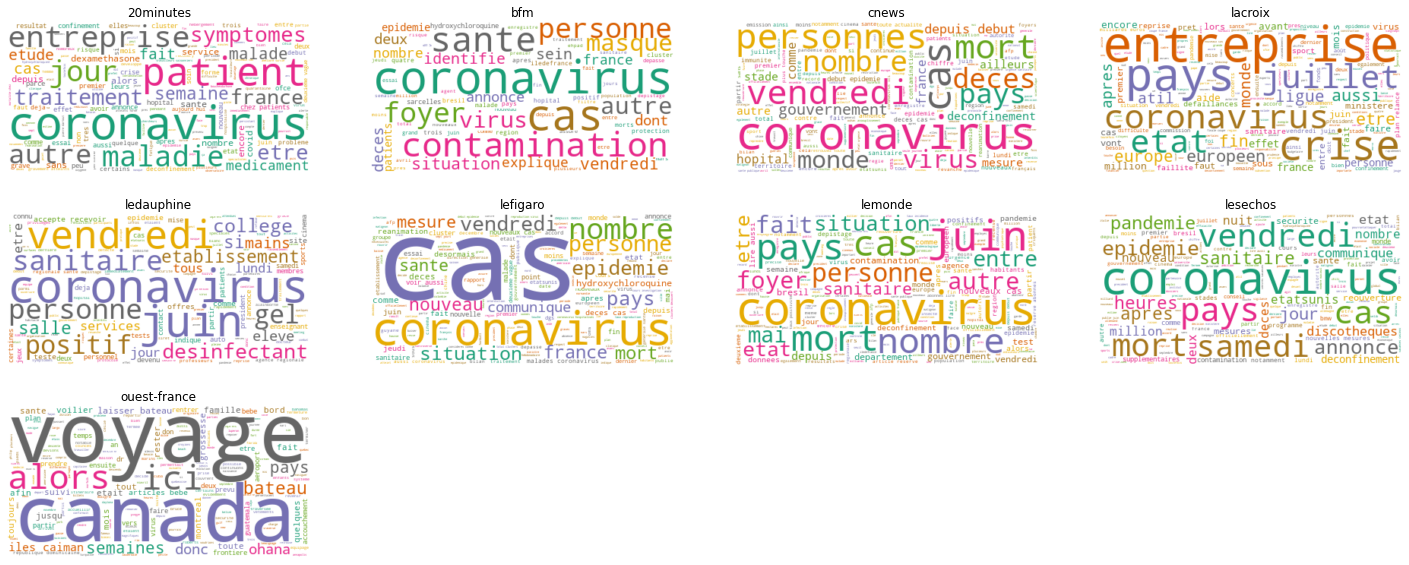

In [56]:
from wordcloud import WordCloud

stopwords = ['a', '<NB>', 'ete', 'plus', 'cette', 'NB', 'nb', '<nb>', 'selon']
wc = WordCloud(stopwords=stopwords, background_color="white", colormap="Dark2",
               max_font_size=150, random_state=0)

# Reset the output dimensions
import matplotlib.pyplot as plt

plt.rcParams['figure.figsize'] = [25, 10]

# Create subplots for each comedian
for index, newspaper in enumerate(press['newspaper'].values):
    wc.generate(press[press['newspaper'] == newspaper]['relevent_text'].values[0])
    
    plt.subplot(3, 4, index+1)
    plt.imshow(wc, interpolation="bilinear")
    plt.axis("off")
    plt.title(newspaper)
    
plt.show()

### Résultats

* Le 20minutes parle de la pathologie, du patient, du traitement ; des aspects plutôt médicaux
* CNEWS est plutôt pessimiste et parle des cas, morts ainsi que de leur nombre
* Lacroix s'intéresse aux entrprises et à l'économie

## Les thèmes

In [65]:
from gensim.test.utils import common_texts
from gensim.corpora.dictionary import Dictionary
from gensim.models import LdaModel

common_texts = [text.split(' ') for text in press['relevent_text']]
common_dictionary = Dictionary(common_texts)
common_corpus = [common_dictionary.doc2bow(text) for text in common_texts]

lda = LdaModel(common_corpus, id2word=common_dictionary, num_topics=3, iterations=40, passes=10)

In [66]:
for i in range(len(common_corpus)):
    print(lda[common_corpus[i]])

[(2, 0.99982715)]
[(0, 0.9996464)]
[(0, 0.9997052)]
[(0, 0.9997072)]
[(0, 0.9990662)]
[(0, 0.9996671)]
[(0, 0.9998006)]
[(0, 0.9996744)]
[(0, 0.998806)]


In [67]:
clusters = {}

for i, newspaper in enumerate(press['newspaper']):
    highest_proba = 0
    id_max = 0
    for cluster_id, proba in lda[common_corpus[i]]:
        if cluster_id not in clusters:
            clusters[cluster_id] = []
        if highest_proba < proba:
            id_max = cluster_id
            highest_proba = proba
    clusters[id_max].append(newspaper)
clusters

{2: ['20minutes'],
 0: ['bfm',
  'cnews',
  'lacroix',
  'ledauphine',
  'lefigaro',
  'lemonde',
  'lesechos',
  'ouest-france']}

In [68]:
lda.print_topics()

[(0,
  '0.048*"a" + 0.011*"coronavirus" + 0.009*"plus" + 0.009*"cas" + 0.007*"ete" + 0.005*"pays" + 0.005*"vendredi" + 0.005*"sante" + 0.005*"epidemie" + 0.004*"nombre"'),
 (1,
  '0.002*"a" + 0.001*"cas" + 0.001*"coronavirus" + 0.001*"plus" + 0.000*"ete" + 0.000*"nombre" + 0.000*"epidemie" + 0.000*"cette" + 0.000*"pays" + 0.000*"patients"'),
 (2,
  '0.034*"a" + 0.011*"patients" + 0.011*"coronavirus" + 0.005*"plus" + 0.005*"ete" + 0.004*"sante" + 0.004*"chez" + 0.004*"cas" + 0.004*"symptomes" + 0.004*"entreprises"')]

In [70]:
from nltk import word_tokenize, pos_tag

def nouns(text):
    '''Given a string of text, tokenize the text and pull out only the nouns.'''
    is_noun = lambda pos: pos[:2] == 'NN'
    tokenized = word_tokenize(text)
    all_nouns = [word for (word, pos) in pos_tag(tokenized) if is_noun(pos)] 
    return all_nouns

common_texts = [nouns(text) for text in press['relevent_text']]
common_dictionary = Dictionary(common_texts)
common_corpus = [common_dictionary.doc2bow(text) for text in common_texts]

lda = LdaModel(common_corpus, id2word=common_dictionary, num_topics=3, iterations=40, passes=10)

In [71]:
lda.print_topics()

[(0,
  '0.001*"patients" + 0.001*"coronavirus" + 0.001*"cas" + 0.001*"france" + 0.000*"cette" + 0.000*"juin" + 0.000*"pays" + 0.000*"deces" + 0.000*"vendredi" + 0.000*"annonce"'),
 (1,
  '0.013*"coronavirus" + 0.009*"patients" + 0.009*"cas" + 0.006*"personnes" + 0.006*"france" + 0.006*"sante" + 0.005*"selon" + 0.005*"deces" + 0.005*"cette" + 0.004*"morts"'),
 (2,
  '0.010*"coronavirus" + 0.007*"juin" + 0.006*"pays" + 0.006*"cette" + 0.005*"vendredi" + 0.005*"cas" + 0.004*"morts" + 0.004*"juillet" + 0.004*"france" + 0.003*">"')]

## Positivité vs négativité & subjectivité

In [62]:
from textblob import TextBlob
from textblob_fr import PatternTagger, PatternAnalyzer


pol = lambda x: TextBlob(x, pos_tagger=PatternTagger(), analyzer=PatternAnalyzer()).sentiment[0]
sub = lambda x: TextBlob(x, pos_tagger=PatternTagger(), analyzer=PatternAnalyzer()).sentiment[1]

data = press[['newspaper']].copy()
data['polarity'] = press['relevent_text'].apply(pol)
data['subjectivity'] = press['relevent_text'].apply(sub)
data

,newspaper,polarity,subjectivity
0,20minutes,0.061362,0.231478
1,bfm,0.072447,0.164847
2,cnews,0.064236,0.289824
3,lacroix,0.072340,0.283104
4,ledauphine,0.122500,0.175000
5,lefigaro,0.051925,0.162117
6,lemonde,0.069265,0.163300
7,lesechos,0.083109,0.169934
8,ouest-france,0.096385,0.196154


Text(0.5, 0, 'Polarité')

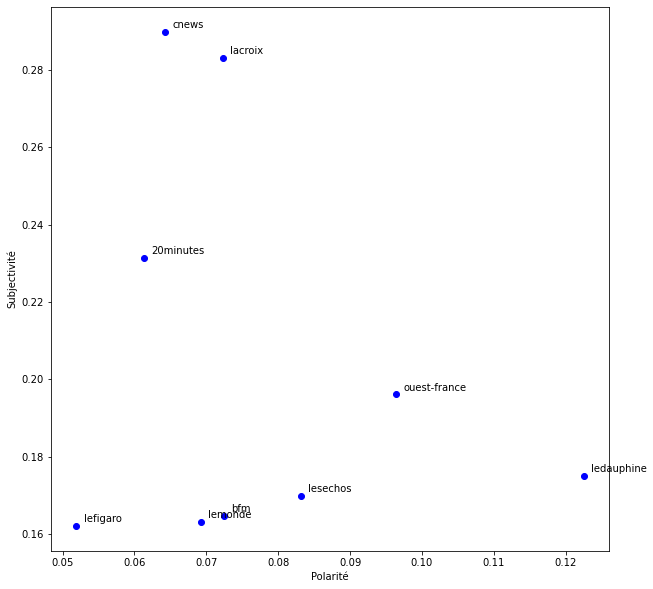

In [63]:
fig, ax = plt.subplots(figsize=(10, 10))

for newspaper, row in zip(data['newspaper'], data[['polarity', 'subjectivity']].values):
    x = row[0]
    y = row[1]
    ax.scatter(x, y, color='blue')
    ax.text(x+0.001, y+0.001, newspaper)

ax.set_ylabel('Subjectivité')
ax.set_xlabel('Polarité')

### Résultats

* Les journaux les plus subjectifs ont tendance à être plus négatif que les autres.

## Longueur et nombre de mots par article

In [64]:
from urls import *
from statistics import median

newspapers = URLS.keys()
nb_articles = {newspaper: len(urls) for newspaper, urls in zip(newspapers, URLS)}

def mean_length_sentences(text):
    sentences = text.split('.')
    res = 0
    for sentence in sentences:
        length = len(sentence.split(' '))
        res += length
    return res / len(sentences)

def median_length_sentences(text):
    sentences = text.split('.')
    lengths = []
    for sentence in sentences:
        lengths.append(len(sentence.split(' ')))
    return median(lengths)

words_per_articles = [len(text.split(' ')) / nb_articles[newspaper] for newspaper, text in zip(press['newspaper'], press['text'])]
sentences_mean_lengths = [mean_length_sentences(text) for text in press.set_index('newspaper').loc[newspapers]['text']]
sentences_median_lengths = [median_length_sentences(text) for text in press.set_index('newspaper').loc[newspapers]['text']]

texts_stats = pd.DataFrame()
texts_stats['number of articles'] = nb_articles.values()
texts_stats['words per articles'] = words_per_articles
texts_stats['sentences mean length'] = sentences_mean_lengths
texts_stats['sentences median length'] = sentences_median_lengths
texts_stats = texts_stats.set_index(press['newspaper']).round(2)
texts_stats

,number of articles,words per articles,sentences mean length,sentences median length
newspaper,,,,
20minutes,3,778.11,21.21,21.0
bfm,9,1078.33,22.41,22.0
cnews,5,770.60,19.43,17.0
lacroix,12,597.57,21.53,18.0
ledauphine,10,124.80,23.67,21.0
lefigaro,7,438.25,27.02,26.0
lemonde,8,836.57,19.26,18.0
lesechos,8,446.75,21.30,18.0
ouest-france,7,87.33,27.47,25.0


### Résultats

* CNEWS et LeMonde produisent les phrases les plus courtes avec 17 et 18 mots par phrase (médian)
* LeFigaro produit les phrases les plus longues avec 27 mots en moyenne
* BFM produit les articles les plus longs avec plus de 1000 mots par article. C'est LeDauphiné qui produit les articles les plus courts avec 124 mots par article.